<a href="https://colab.research.google.com/github/TiffanyDegbotse/Explainable-Deep-Learning/blob/main/explainable_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Tiffany Abui Degbotse

## Dataset:

Krizhevsky, A. (2009). Learning Multiple Layers of Features from Tiny Images (CIFAR-10). University of Toronto. https://www.cs.toronto.edu/~kriz/cifar.html

## Model:

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770–778. https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html

## For this experiment, I selected the CIFAR-10 dataset, which consists of low-resolution (32×32) images across ten categories, including airplanes, automobiles, ships, trucks, and horses. The goal of this project is to explore how pretrained models like ResNet-50 interpret and focus on visual cues related to different forms of transportation and movement, which are central to real-world applications such as road safety, autonomous navigation, and mobility perception. Although CIFAR-10 is smaller and lower in quality than ImageNet, it reflects realistic conditions where computer vision systems must operate with limited resolution, such as blurry surveillance footage or compressed traffic camera feeds. Using this dataset makes it possible to analyze how a high-capacity model trained on high-resolution images generalizes to smaller, noisier inputs, providing valuable insight into the stability and interpretability of Grad-CAM, GRADCAM ++ and SCORECAM under domain shift and imperfect visual environments.

## Installations

In [1]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
!pip install timm==1.0.7
!pip install opencv-python==4.10.0.84
!pip install pillow==10.4.0 matplotlib==3.9.2
!pip install pytorch-grad-cam==1.5.0
!pip install grad-cam==1.5.0
!pip install kaggle==1.6.14



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam==1.5.0 (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam==1.5.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38172 sha256=21525f282b8323112641ca2cd633bac741309a0c0f40d98867e3cd8346dd1ece
  Stored in directory: /root/.cache/pip/wheels/12/7c/bc/d89b695716bae192c348baefb8e4a0be6d0848d3976a7cfe67
Successfully built grad-cam


## Initial Imports

In [1]:
import torch, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## Load Pre-Trained ResNet-50 Model
## I set it to eval mode because I will be using GRAD-CAM for visualizations hence a purely inference task

In [3]:
# Loading the default pretrained weights for ResNet-50 (trained on ImageNet)
weights = models.ResNet50_Weights.DEFAULT

# Initializing the ResNet-50 model with these weights
# Moving it to the appropriate device (CPU in my case from the run cell above) and setting it to evaluation mode (for inference)
model = models.resnet50(weights=weights).to(device).eval()


## Initialize ImageNet Preprocessing and Labels

In [4]:
# Getting the preprocessing transforms directly from the pretrained weights for correctness
preprocess = weights.transforms()

# Retrieving the class labels (ImageNet category names)
labels = weights.meta["categories"]


## Load and Preprocess the CIFAR-10 Dataset
## I am focusing on travel safety so I would be focused on "airplane,automobile,horse,ship and truck"

In [10]:
import torchvision.datasets as dsets
import torchvision.transforms as T

#Focused on normalizing the images to mimic the ImageNet dataset
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

cifar10 = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print("Classes:", cifar10.classes)

img, label = cifar10[0]
print("Example class:", cifar10.classes[label])



Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Example class: cat


## Set up target layer

In [12]:
target_layers = [model.layer4[-1]]  # last conv block


## Adding GradCam and variants

 ## Because CIFAR-10 images are low-resolution, ResNet-50 sometimes mapped airplanes to unrelated ImageNet classes like ‘can opener.’ However, the Grad-CAM heatmaps still consistently highlighted the plane region, showing that explainability reveals the model’s focus even when predictions are off.

 ## For the first image, restnet is predicting can opener instead of airplane and we see that the body of the airplane is the main part that makes that prediction. The background of the airplane doesn't play much of a role hence why it may be getting  it wrong and predicting a can opener. We see the same thing for GRADCAM ++ and SCORECAM.

 ## For the second image, we see the automobile is being identified as a moving van. We see the main part contributing to that prediction is the wheels of the automobile. This is the case for GRADCAM,GRADCAM++ and SCORECAM.

 ## For the third image, we see that the image is being correctly identified as a ship. We see that for GRADCAM and GRADCAM ++, the base and back of the ship are the main parts contributing to the description but for SCORECAM, the entire body of the ship is the main contributor to the description.

 ## For the fourth image, we see that the front of the truck (headlight) and the door are the main contributors to the prediction "moving van".This is the case for GRADCAM and GRADCAM++ but for SCORECAM, we see that the side of the truck (the door), around where the other headlights (not the one detected with GRADCAM and GRADCAM++) is the main contributor to the prediction.

 ## For the fifth image, we see that the legs of the horse and a part of its body, are used to predict "packet" for GRADCAM and GRADCAM++ but for ScoreCAM, the entire body of the horse is considered in prediction but still predicts packet.

Picked indices: [496, 9907, 7320, 1439, 6500]

Image 496 | CIFAR-10 label: airplane | Predicted: can opener


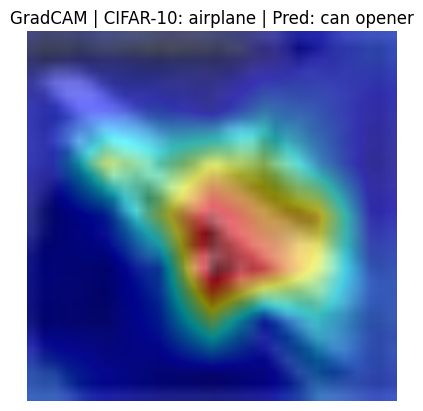

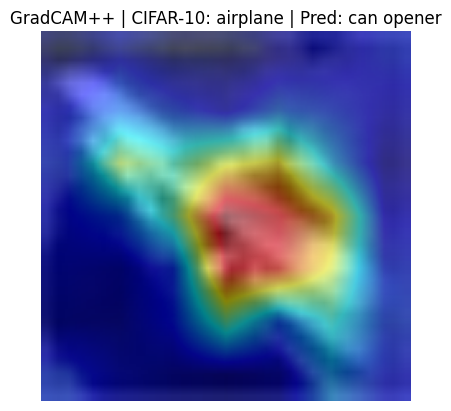

100%|██████████| 128/128 [08:30<00:00,  3.99s/it]


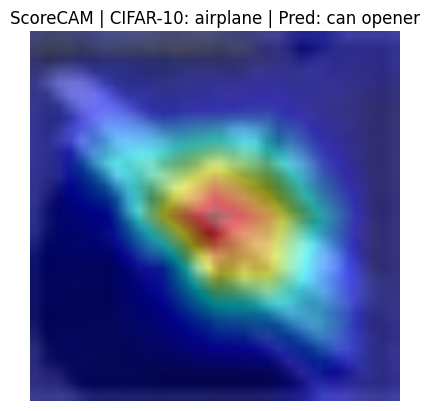


Image 9907 | CIFAR-10 label: automobile | Predicted: moving van


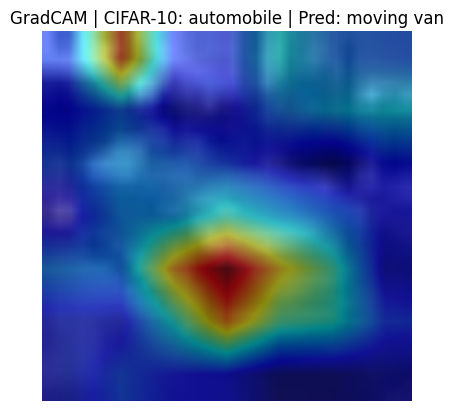

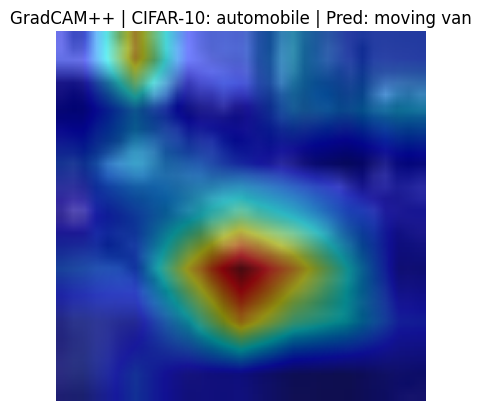

100%|██████████| 128/128 [07:21<00:00,  3.45s/it]


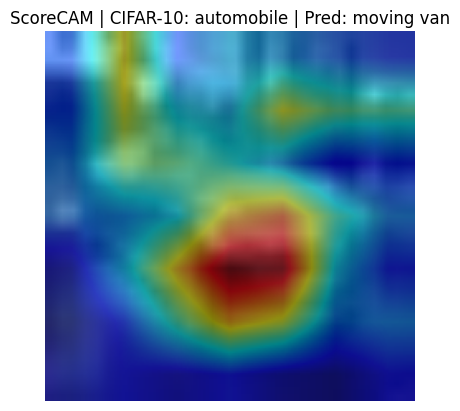


Image 7320 | CIFAR-10 label: ship | Predicted: container ship


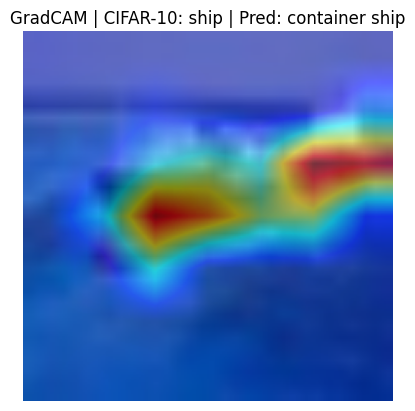

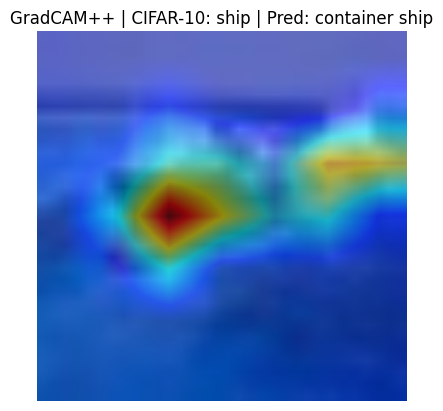

100%|██████████| 128/128 [07:06<00:00,  3.33s/it]


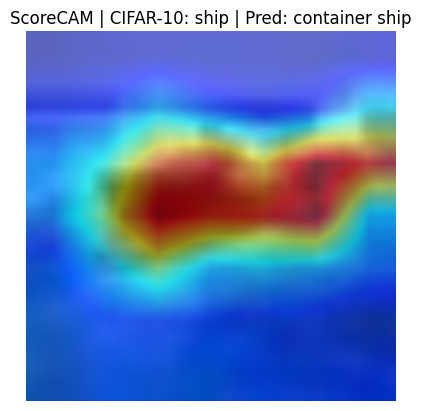


Image 1439 | CIFAR-10 label: truck | Predicted: moving van


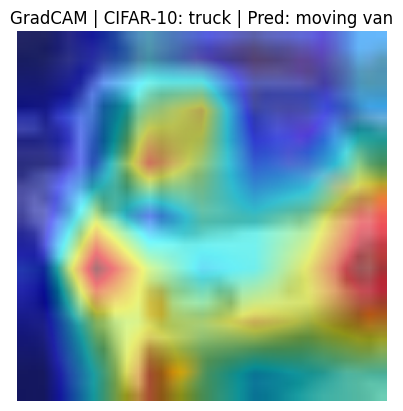

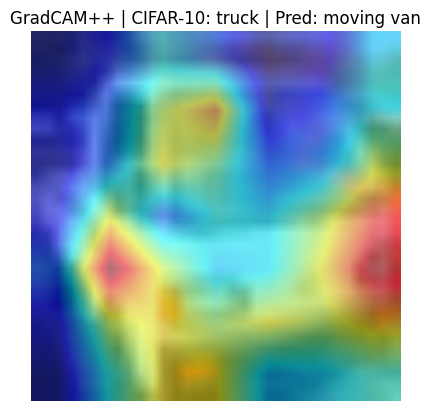

100%|██████████| 128/128 [07:56<00:00,  3.72s/it]


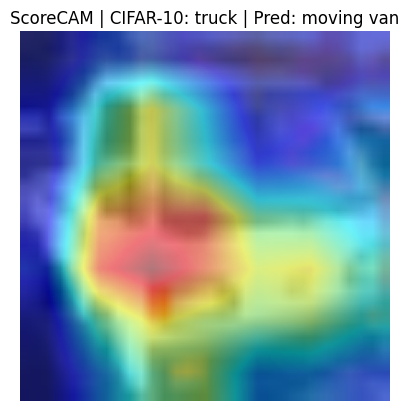


Image 6500 | CIFAR-10 label: horse | Predicted: packet


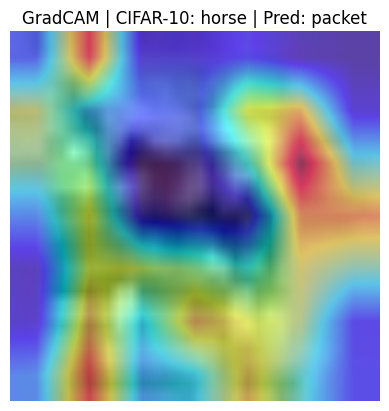

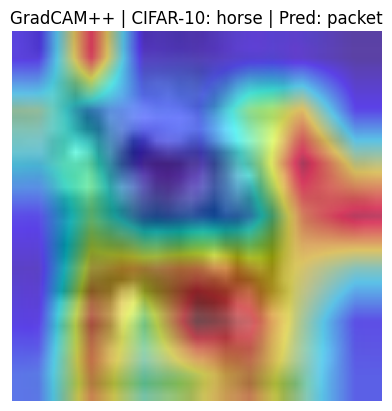

100%|██████████| 128/128 [07:39<00:00,  3.59s/it]


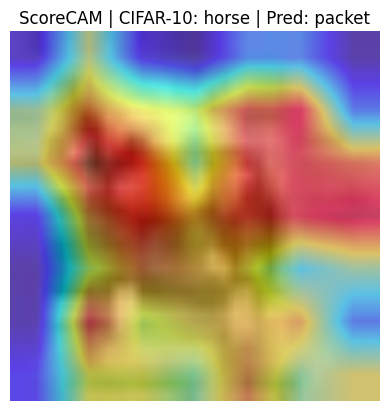

In [13]:
imagenet_classes = weights.meta["categories"]
import random

# Define travel-related classes
travel_classes = {
    "airplane": 0,
    "automobile": 1,
    "ship": 8,
    "truck": 9,
    "horse": 7
}

# Pick one random sample from each class
sample_indices = []
for cname, cidx in travel_classes.items():
    indices = [i for i, (_, y) in enumerate(cifar10) if y == cidx]
    #The above code snippet was generated using chatgpt on 10/04/24 at 8:00pm.

    sample_indices.append(random.choice(indices))

print("Picked indices:", sample_indices)

# Grad-CAM methods
cam_methods = {
    "GradCAM": GradCAM,
    "GradCAM++": GradCAMPlusPlus,
    "ScoreCAM": ScoreCAM,
}

# Run CAMs on chosen samples
for idx in sample_indices:
    img, label = cifar10[idx]
    input_tensor = img.unsqueeze(0).to(device)
    #The above code snippet was generated using chatgpt on 10/04/24 at 8:05pm.

    # prepare image for overlay (denormalize)
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    #The above code snippet was generated using chatgpt on 10/04/24 at 8:15pm.

    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

    print(f"\nImage {idx} | CIFAR-10 label: {cifar10.classes[label]} | "
          f"Predicted: {imagenet_classes[pred_class]}")

    # Run each CAM method
    for name, CAM in cam_methods.items():
        with CAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=[ClassifierOutputTarget(pred_class)])[0]

            visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

            plt.imshow(visualization)
            plt.title(f"{name} | CIFAR-10: {cifar10.classes[label]} | "
                      f"Pred: {imagenet_classes[pred_class]}")
            plt.axis("off")
            plt.show()


## Overall, the results show that even when pretrained models like ResNet-50 encounter low-resolution CIFAR-10 images, Grad-CAM and its variants still provide meaningful interpretability. For example, while the model predicted "can opener" for an airplane image due to texture confusion, the activation maps correctly focused on the airplane’s body, indicating that the model attends to relevant regions even when the prediction is incorrect. The automobile identified as a "moving van" was a reasonable classification within the same vehicle category, with the wheels emerging as the key features across all three methods. The ship image was correctly classified, with Grad-CAM and Grad-CAM++ focusing on the base and back of the ship, while Score-CAM highlighted the entire body. For the truck image, the headlights and door were the main contributing regions in Grad-CAM and Grad-CAM++, whereas Score-CAM emphasized the opposite side of the vehicle. Finally, for the horse image, Grad-CAM and Grad-CAM++ emphasized the legs and part of the body, while Score-CAM considered the entire horse but still produced the incorrect "packet" prediction. These findings demonstrate that explainability methods reveal consistent model attention patterns across different Grad-CAM variants, even when predictions vary. Using CIFAR-10 allowed this analysis to simulate realistic low-quality visual conditions, showing that interpretability techniques remain useful for uncovering model reasoning and biases under domain shift.

## This was additional code I added to make sure I was seeing the right thing when explaining the GRADCAM results since the images were a bit hard to see.

Displaying the real images used for Grad-CAM:
Indices: [496, 9907, 7320, 1439, 6500]


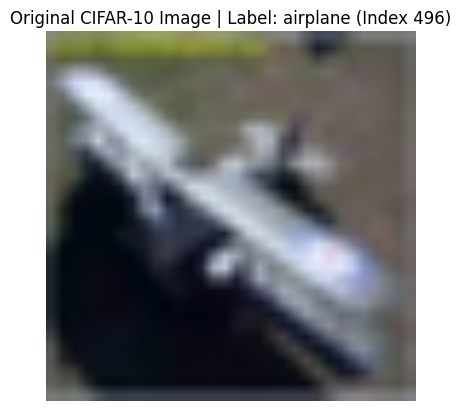

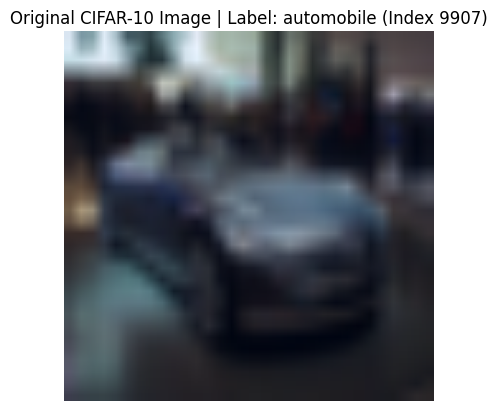

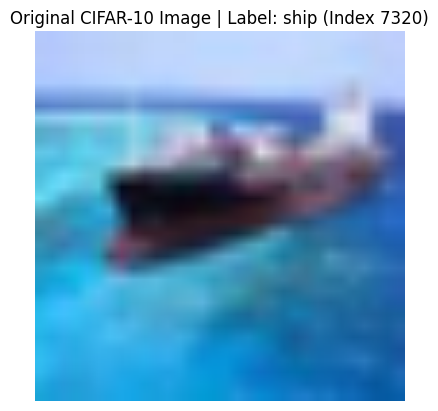

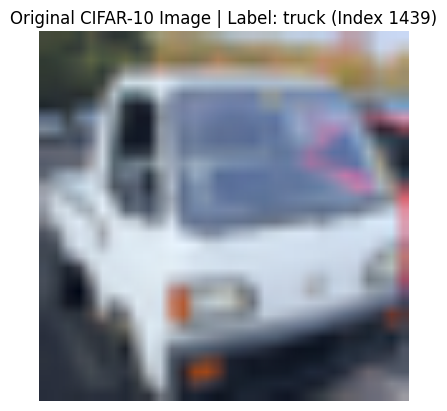

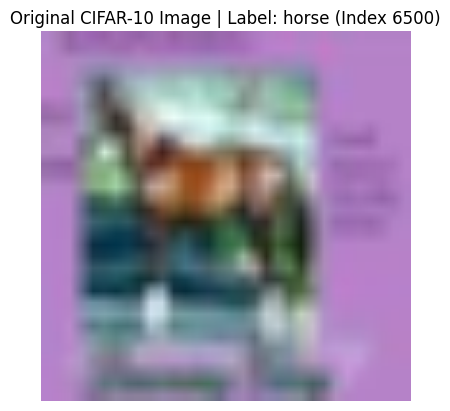

In [14]:
# Displaying the original CIFAR-10 images used in the Grad-CAM loop
import matplotlib.pyplot as plt

# Making sure sample_indices is defined from your earlier Grad-CAM code
print("Displaying the real images used for Grad-CAM:")
print("Indices:", sample_indices)

for idx in sample_indices:
    img, label = cifar10[idx]

    # Denormalize for display (convert from tensor to RGB)
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.imshow(img_np)
    plt.title(f"Original CIFAR-10 Image | Label: {cifar10.classes[label]} (Index {idx})")
    plt.axis("off")
    plt.show()
